In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from scipy.stats import entropy as scipy_entropy
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import pandas as pd
import ast
import zipfile
import os

In [2]:
monk_path = "monk-20250317T224613Z-001.zip"
uvs_monk_path = "UVs_monk-20250317T224652Z-001.zip"
uvs_path = "UVs-20250317T224636Z-001.zip"

monk_extract_path = "monk"
uvs_monk_extract_path = "uvs_monk"
uvs_extract_path = "uvs"

with zipfile.ZipFile(monk_path, 'r') as zip_ref:
    zip_ref.extractall(monk_extract_path)

with zipfile.ZipFile(uvs_monk_path, 'r') as zip_ref:
    zip_ref.extractall(uvs_monk_extract_path)

with zipfile.ZipFile(uvs_path, 'r') as zip_ref:
    zip_ref.extractall(uvs_extract_path)

## Funções basicas

Função upload_images() modificada para trabalhar com **diretório local** ao invés de ter que fazer o upload pro colab (que demora). Agora essa função recebe como argumento o caminho pra nossa pasta (não zipada) com as imagens

In [3]:
def upload_images(path):
    images = []
    for filename in os.listdir(path):
        full_path = os.path.join(path, filename)
        img = cv2.imread(full_path)
        images.append((filename, img))
    return images

def detectar_rosto(imagem):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        roi = imagem[y:y+h, x:x+w]
        return roi, (x, y, w, h)
    else:
        return None, None

## Funções e explicações

Lista de variáveis que serão plotadas para cada grupo:

1. 'Média RGB': Representa a média dos valores de Red, Green e Blue (componentes de cor) em uma imagem.
   Essa métrica fornece uma ideia da intensidade média de cores da imagem.

2. 'Red Ratio': Proporção da componente vermelha (Red) em relação às demais componentes de cor na imagem.
   Indica o quanto a cor vermelha contribui para o espectro de cores da imagem.

3. 'Green Ratio': Proporção da componente verde (Green) em relação às outras cores.
   Da mesma forma, mede a participação do verde no conjunto total de cores da imagem.

4. 'Blue Ratio': Proporção da componente azul (Blue) em relação ao espectro total.
   Ajuda a identificar a predominância de tons azuis na imagem.

5. 'RGB Range': Diferença entre os valores máximos e mínimos de RGB na imagem.
   Representa a variação de cores, ou a amplitude de tons presentes na imagem.

6. 'Contraste': Mede a diferença de intensidade entre os pixels mais claros e os mais escuros na imagem.
   Imagens com alto contraste têm uma grande variação de luz e sombra.

7. 'Correlação': Indica o grau de similaridade entre pixels próximos em termos de intensidade.
   Uma alta correlação significa que os pixels vizinhos têm valores de intensidade parecidos.

8. 'Energia': Reflete a uniformidade da distribuição de intensidades na imagem.
   Uma alta energia indica que a imagem tem poucas variações abruptas de intensidade.

9. 'Homogeneidade': Mede o quão uniformemente os valores de intensidade estão distribuídos em uma imagem.
   Uma alta homogeneidade sugere que a imagem tem uma textura uniforme, com pequenas variações de intensidade.

10. 'Dissimilaridade': É o oposto da homogeneidade, medindo a diferença de intensidade entre pixels vizinhos.
    Uma alta dissimilaridade significa que há grandes variações de intensidade entre os pixels.

11. 'Entropia (Shannon)': Mede a incerteza ou aleatoriedade da distribuição de intensidades na imagem, baseada na entropia de Shannon.
    Uma entropia alta indica maior complexidade e variabilidade nas intensidades.

12. 'Entropia (Histograma)': Entropia calculada com base na distribuição do histograma das intensidades.
    Também reflete a variabilidade, mas levando em conta a distribuição das frequências dos níveis de intensidade.

13. 'Intensidade média': Valor médio de intensidade dos pixels na imagem.
    Indica a quantidade média de luz ou escuridão presente.

14. 'Intensidade mediana': O valor da intensidade que divide a imagem em duas partes iguais, com metade dos pixels abaixo e metade acima desse valor.
    É uma medida de tendência central menos sensível a extremos (valores muito altos ou muito baixos).

15. 'Desvio padrão da intensidade': Mede a variação da intensidade dos pixels em torno da média.
    Um desvio padrão alto indica que as intensidades estão mais espalhadas (mais diversidade de brilho).

16. 'Intensidade mínima': O valor mais baixo de intensidade de pixel presente na imagem.
    Representa o pixel mais escuro.

17. 'Intensidade máxima': O valor mais alto de intensidade de pixel na imagem.
    Representa o pixel mais claro ou brilhante.

In [4]:
# Função para calcular a entropia e outras métricas de iluminação
def analisar_iluminacao(gray_roi):
    hist = cv2.calcHist([gray_roi], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()

    entropia_shannon = shannon_entropy(gray_roi)
    entropia_histograma = scipy_entropy(hist_norm + 1e-9)  # Evitar log(0)
    intensidade_media = np.mean(gray_roi)
    intensidade_mediana = np.median(gray_roi)
    desvio_padrao_intensidade = np.std(gray_roi)
    intensidade_minima = np.min(gray_roi)
    intensidade_maxima = np.max(gray_roi)
    '''
    Entropia (Shannon):
    Significado: Mede a aleatoriedade ou imprevisibilidade dos valores de pixel.
    Importância: Valores altos indicam imagens com mais detalhes ou texturas complexas.


    Entropia (Histograma):
    Significado: Mede a aleatoriedade da distribuição de intensidades.
    Importância: Útil para avaliar o contraste e a distribuição geral de tons na imagem.


    Intensidade média:
    Significado: Brilho médio da imagem.
    Importância: Indica se a imagem é geralmente clara ou escura.


    Intensidade mediana:
    Significado: Valor central de intensidade.
    Importância: Menos afetada por valores extremos que a média, oferece uma medida robusta do brilho geral.


    Desvio padrão da intensidade:
    Significado: Variação das intensidades em relação à média.
    Importância: Indica o contraste global da imagem.


    Intensidade mínima e máxima:
    Significado: Valores extremos de intensidade na imagem.
    Importância: Úteis para avaliar o range dinâmico e potenciais problemas de sub ou superexposição.
    '''

    return {
        "Entropia (Shannon)": entropia_shannon,
        "Entropia (Histograma)": entropia_histograma,
        "Intensidade média": intensidade_media,
        "Intensidade mediana": intensidade_mediana,
        "Desvio padrão da intensidade": desvio_padrao_intensidade,
        "Intensidade mínima": intensidade_minima,
        "Intensidade máxima": intensidade_maxima
    }

In [5]:
# Função para analisar a imagem
def analisar_imagem(imagem, roi=None):
    if roi is None:
        roi = imagem

    # Converter para diferentes espaços de cor
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)

    # Média de cor nos diferentes espaços
    mean_rgb = np.mean(roi_rgb, axis=(0, 1))
    mean_hsv = np.mean(roi_hsv, axis=(0, 1))
    mean_lab = np.mean(roi_lab, axis=(0, 1))

    # Análise de textura Haralick
    textura = analisar_textura_haralick(roi)

    # Análise de Iluminação
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    iluminacao = analisar_iluminacao(gray_roi)
    '''
    RGB: Representação padrão de cores.
    HSV: Separa a informação de cor (matiz e saturação) da intensidade.
    LAB: Projetado para se aproximar da percepção humana de cor.
    '''
    results = {
        "Média RGB": mean_rgb,
        "Média HSV": mean_hsv,
        "Média LAB": mean_lab,
        **textura,
        **iluminacao
    }

    return results

In [6]:
# Função para calcular métricas Haralick de textura
def analisar_textura_haralick(roi):
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_roi, [5], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    '''
    Contraste:
    Significado: Mede a variação local de intensidade na imagem.
    Importância: Valores altos indicam texturas com mudanças abruptas de intensidade.


    Correlação:
    Significado: Mede a dependência linear dos níveis de cinza entre pixels vizinhos.
    Importância: Indica a presença de estruturas lineares na textura.


    Energia:
    Significado: Também conhecida como uniformidade, mede a soma dos elementos ao quadrado na GLCM.
    Importância: Valores altos indicam texturas mais uniformes ou repetitivas.


    Homogeneidade:
    Significado: Mede a proximidade da distribuição de elementos na GLCM à diagonal da GLCM.
    Importância: Valores altos indicam texturas com pouca variação local.


    Dissimilaridade:
    Significado: Mede a variação de pares de níveis de cinza.
    Importância: Similar ao contraste, mas com peso linear em vez de quadrático.
    '''
    return {
        "Contraste": contrast,
        "Correlação": correlation,
        "Energia": energy,
        "Homogeneidade": homogeneity,
        "Dissimilaridade": dissimilarity
    }


## Processamento das imagens

In [7]:
# Função para processar múltiplas imagens
def processar_imagens(imagens, show=True):
    resultados = []
    for filename, img in imagens:
        filename = filename.replace(".png", "")
        roi, face_coords = detectar_rosto(img)
        if roi is not None:
            results = analisar_imagem(img, roi)
        else:
            results = analisar_imagem(img)
        results["Filename"] = filename
        resultados.append(results)

        if show:
            # Plotar a imagem
            print(f"Processando imagem: {filename}")
            plt.figure(figsize=(10, 5))
            plt.subplot(121)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title('Imagem Original')
            plt.axis('off')
            if face_coords:
                x, y, w, h = face_coords
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))

            plt.subplot(122)
            # plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title('Região de Interesse (ROI)')
            plt.axis('off')
            plt.show()

    return resultados

In [8]:
# Carregar múltiplas imagens
uvs_monk_images = upload_images("uvs_monk/UVs_monk/")

uvs_monk_images = processar_imagens(uvs_monk_images, show=False)#Mude para True caso queira ver as imagens

## Criação da tabela (csv)

In [9]:
# Função para corrigir entradas mal formatadas
def fix_list_format(text):
    # Verifica se o input já é uma lista ou array
    if isinstance(text, (list, tuple, np.ndarray)):
        return text  # Se já for uma lista, não faz nada

    # Caso contrário, aplica a formatação para strings
    text = text.replace(' ', ',').strip('[]')
    text = text.replace(',,', ',').strip('[]')  # Remove vírgulas extras e colchetes
    elements = [x for x in text.split(',') if x]  # Remove entradas vazias
    return '[' + ','.join(elements) + ']'  # Recria o formato de lista válido

# Função para aplicar as correções e conversões
def process_dataframe(df):
    # Corrigir formatação nas colunas de listas
    df['Média RGB'] = df['Média RGB'].apply(fix_list_format)
    df['Média HSV'] = df['Média HSV'].apply(fix_list_format)
    df['Média LAB'] = df['Média LAB'].apply(fix_list_format)

    # Aplicar literal_eval para converter string em lista
    df['Média RGB'] = df['Média RGB'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['Média HSV'] = df['Média HSV'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['Média LAB'] = df['Média LAB'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    return df

# Função para calcular as proporções RGB e intervalo RGB sem modificar o DataFrame
def calcular_rgb(df):
    # Separar os componentes RGB
    RGB_values = df['Média RGB'].apply(pd.Series)
    R = RGB_values[0]
    G = RGB_values[1]
    B = RGB_values[2]

    # Calcular as proporções
    df['Red Ratio'] = R / (R + G + B)
    df['Green Ratio'] = G / (R + G + B)
    df['Blue Ratio'] = B / (R + G + B)

    # Calcular o intervalo RGB
    df['RGB Range'] = RGB_values.max(axis=1) - RGB_values.min(axis=1)

    # Calcular a média rgb
    df['Média RGB'] = (R + G + B) / 3

    return df

In [10]:
df_uvs_monk = pd.DataFrame(uvs_monk_images)

df_uvs_monk = process_dataframe(df_uvs_monk)

# Calcular as proporções e intervalos RGB
df_uvs_monk = calcular_rgb(df_uvs_monk)

# Salvar os resultados em um arquivo CSV, se necessário
df_uvs_monk.to_csv('uvs_monk_images_results.csv', index=False)
print("Os resultados foram salvos em 'uvs_monk_images_results.csv'")
df_uvs_monk

Os resultados foram salvos em 'uvs_monk_images_results.csv'


,Média RGB,Média HSV,Média LAB,Contraste,Correlação,Energia,Homogeneidade,Dissimilaridade,Entropia (Shannon),Entropia (Histograma),Intensidade média,Intensidade mediana,Desvio padrão da intensidade,Intensidade mínima,Intensidade máxima,Filename,Red Ratio,Green Ratio,Blue Ratio,RGB Range
0,173.715030,"[12.57032427839149, 61.795455168443844, 199.77...","[182.5929387900551, 136.52613689317727, 141.51...",385.468868,0.747068,0.063081,0.220731,11.046473,6.266253,4.343437,176.576026,178.0,27.249264,17,214,keiji_joy_1,0.383348,0.325374,0.291278,47.981936
1,76.614634,"[10.498282467961422, 114.94563350508653, 99.88...","[82.43295019157088, 139.47476549081782, 140.09...",960.326056,0.698642,0.027460,0.116210,15.400939,6.746250,4.676146,78.035837,69.0,42.422948,5,204,keiji_joy_10,0.434576,0.306826,0.258598,40.447450
2,164.069976,"[11.023992679230176, 73.03305785123968, 194.01...","[173.70645428808373, 138.2721553375847, 143.54...",436.218634,0.725051,0.044722,0.187598,12.101046,6.415968,4.447212,167.233149,177.0,27.844966,14,208,keiji_joy_2,0.394169,0.323139,0.282692,54.869942
3,161.439666,"[10.908090022591438, 74.70196459721467, 191.76...","[171.1885384197432, 138.50587663358976, 143.72...",444.281307,0.713604,0.045046,0.191383,12.193865,6.410105,4.443148,164.614630,175.0,27.562860,13,206,keiji_joy_3,0.395944,0.322696,0.281360,55.494981
4,159.693235,"[12.382322485207101, 45.117396449704145, 175.8...","[168.5894674556213, 133.43426035502958, 137.12...",305.545988,0.852914,0.132088,0.484233,7.923514,5.762832,3.994493,161.632825,174.0,31.972296,13,204,keiji_joy_4,0.367088,0.328650,0.304261,30.099186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,128.744193,"[9.245612927660648, 100.70338341118546, 162.94...","[138.68425703825275, 141.61725160964525, 145.8...",1137.883159,0.726231,0.053712,0.184706,18.018835,6.715451,4.654798,131.852039,143.0,45.557352,2,201,tori_sadness_5,0.421884,0.315713,0.262403,61.597052
116,122.429602,"[10.854160681796419, 106.16278847074595, 157.0...","[132.47246959685913, 142.06489195314245, 146.2...",1164.064282,0.720836,0.053719,0.175535,18.132998,6.794444,4.709551,125.582049,134.0,45.810752,2,201,tori_sadness_6,0.427672,0.314517,0.257810,62.388490
117,113.764524,"[9.599986479177934, 111.78907517577069, 147.76...","[123.92462141698215, 141.72404002163333, 146.5...",1144.673339,0.719564,0.050239,0.162833,17.887585,6.862643,4.756823,117.055030,124.0,45.535668,2,200,tori_sadness_7,0.432952,0.314723,0.252325,61.646769
118,99.819249,"[9.568072227352006, 112.69193940015731, 129.55...","[108.71156937177251, 140.79829691187032, 144.0...",1156.873247,0.711665,0.050019,0.158369,17.381667,6.828152,4.732916,102.374987,104.0,45.703092,2,201,tori_sadness_8,0.432600,0.312521,0.254879,53.220102


## *Principal Component Analysis* (PCA)

A análise de componentes principais (PCA) determina o eixo que explica a maior parte da variação presente no conjunto de treinamento e, em seguida, identifica um segundo eixo, ortogonal ao primeiro, que capta a maior parcela da variância que sobrou (<span style="color:blue">GERON,2019</span>).

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Standard Scaler

Aplicando a padronização dos dados, de modo que cada variável tenha média zero e variância igual a 1.

In [ ]:
# Removendo variáveis não numéricas
df_uvs_monk = df_uvs_monk.drop(columns=["Média HSV", "Média LAB", "Filename"])

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_uvs_monk)

### Aplicando o PCA

Vamos transformar os dados originais para um novo espaço reduzido com 2 componentes principais, dos quais são combinações lineares das variáveis originais

In [16]:
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)

In [21]:
print("Dados transformados pelo PCA:")
print(X_pca)
print("\nVariância explicada por cada componente (O 1° componente é o que explica a maior parte dela):")
print(pca.explained_variance_ratio_)

Dados transformados pelo PCA:
[[-5.33070879 -2.05434347]
 [ 2.81272784  1.54920074]
 [-3.51881411 -2.2092357 ]
 [-3.24836803 -2.1543267 ]
 [-8.55097345  0.45732458]
 [-0.34639569 -2.2096854 ]
 [ 0.68423866 -2.1537152 ]
 [ 1.58925077 -2.20635026]
 [ 2.15207103 -1.22149037]
 [ 2.62487716 -0.35931111]
 [-5.14644478 -1.78357686]
 [ 2.98087492  1.64335511]
 [-9.16510046  0.69479043]
 [-8.74388232  0.69715026]
 [-2.56678055 -1.96454213]
 [-7.47076898  0.93256918]
 [ 0.77616925 -1.91992374]
 [ 1.82321773 -2.10325855]
 [ 2.40398112 -1.06526038]
 [ 2.78559302 -0.11294295]
 [-5.21118309 -1.96140136]
 [ 3.09599468  1.16838604]
 [-3.54532513 -2.0439354 ]
 [-9.21253491  0.60349398]
 [-2.48218489 -2.16632773]
 [-7.91511028  0.87948265]
 [ 0.69525554 -1.98197478]
 [ 1.60965928 -2.48738287]
 [ 2.37712968 -1.4350944 ]
 [ 2.81303656 -0.39284776]
 [-3.83670829 -0.58630663]
 [ 3.76182101  0.47195306]
 [-2.3316577  -0.87968939]
 [-1.77942354 -0.95711513]
 [-1.30291857 -1.12798281]
 [ 0.77338191 -1.12079577

### Visualizando os dois componentes que detêm a maior parte da variância dos nossos dados

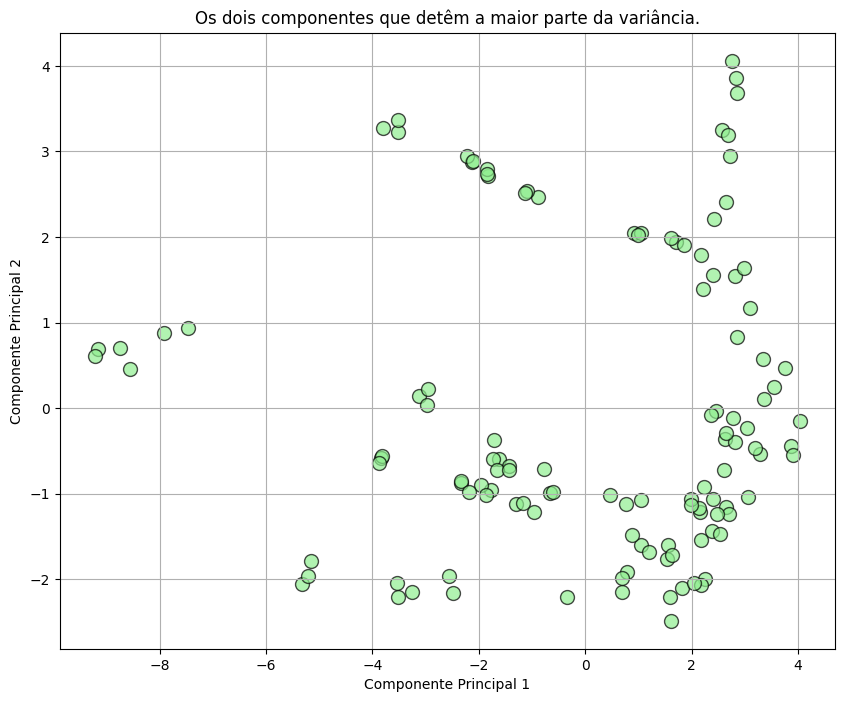

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    color="#90ee90",        # tom de verde claro
    edgecolor="k",          # contorno preto para melhor destaque
    alpha=0.7,              # transparência para visualizar sobreposição
    s=100                   # tamanho dos pontos
)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Os dois componentes que detêm a maior parte da variância.')
plt.grid(True)
plt.show()

In [20]:
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

df_pca.to_csv('uvs_monk_pca.csv', index=False)

## Referências

GERON, A. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts,
Tools, and Techniques to Build Intelligent Systems. 2nd. ed. [S.l.]: O’Reilly Media, Inc., 2019.
ISBN 1492032646. 